In [1]:
#%%

#%%
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
#%%
# Use this file to check that cerebro has loaded the data
# Setup


import backtrader as bt
import os
from datetime import datetime
from datetime import timedelta
from datetime import date
import yfinance as yf
import pandas as pd
import numpy as np
from tqdm import tqdm
import pyfolio as pf
from AlphaGenStrategies import *
from matplotlib import pyplot as plt
import pickle
import time
PATH_TO_SEC_DATA=os.environ['PATH_TO_SEC_DATA']

# Unpickle tickers
print("Unpickling Tickers")
with open(f'{PATH_TO_SEC_DATA}/cerebros/tickers', "rb") as input_file:
    tickers = pickle.load(input_file)

# When to start
initial_date = datetime(2015,1,1)
last_date = datetime.today()
# Adds commissions
# 0.1% ... divide by 100 to remove the %

firstTime = False
if firstTime:
    cerebro = bt.Cerebro()
    print(f"Adding {len(tickers)} tickers")

    tickers = tqdm(tickers)
    not_added = 0
    message = ""

    # Use AAPL as base ticker so that the backtest has the entire span
    df_base = yf.download('AAPL', initial_date.strftime("%Y-%m-%d"), last_date.strftime("%Y-%m-%d"))
    df_base["any"] = 0.0
    df_base = df_base[["any"]]

    for ticker in tickers:
        #tickers.set_description(f"Adding {ticker} - {not_added} tickers failed to meet Cerebro. Last Error : {message} ")
        #tickers.refresh() # to show immediately the update
        # Check if data is in memory
        try:
            time.sleep(1)
            df = yf.download(ticker.lower(), initial_date.strftime("%Y-%m-%d"), last_date.strftime("%Y-%m-%d"))
            df = df_base.join(df)
            df = df.drop(columns=['any'])
            df = df.fillna(0.0)
            # We replace close values for the adj close values, that way we deal with returns at longer frequencies
            df['Close'] = df['Adj Close']
            data = bt.feeds.PandasData(dataname = df)
            cerebro.adddata(data = data, name = ticker)
        except Exception as e:
            message = e
            not_added = not_added + 1
 

    print("Pickling Cerebro")
    filename = f'{PATH_TO_SEC_DATA}/cerebros/cerebro_St'
    outfile = open(filename,'wb')
    pickle.dump(cerebro,outfile)
    outfile.close()

#%%


# Create versions of strategies {'nl': 150, 'ns':50, 'ts' : 'Eret_extended', 'cp' : True},
sts = [{'nl': 75, 'ns':50, 'ts' : 'Fret_extended', 'cp' : True}]


for st in sts:
    print(f"Running Strategy {st}")
    with open(f'{PATH_TO_SEC_DATA}/cerebros/cerebro_St', "rb") as input_file:
        cerebro = pickle.load(input_file)


    cerebro.broker.setcash(1000000.0)
    #cerebro.broker.setcommission(commission=0.001)

    # To analyze data
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')


    cerebro.addstrategy(St, type_signal = st['ts'], 
                        nl=st['nl'], 
                        ns=st['ns'], 
                        correct_precision = st['cp'],
                        verbose = False)

    cp = 1 if st['cp']else 0
    name_st = f"{st['ts']}-{st['nl']}-{st['ns']}-{cp}"
    
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    results =cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())


    strat = results[0]
    pyfoliozer = strat.analyzers.getbyname('pyfolio')

    returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
    transactions.to_csv(f'{PATH_TO_SEC_DATA}/cerebros/transactions_{name_st}')

    # Add the benchmark weights
    benchmark = pd.read_csv(f"{PATH_TO_SEC_DATA}\\cerebros\\benchmark_{name_st}.csv")

    benchmark.index = benchmark.Date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
    benchmark.index = benchmark.index.tz_localize('UTC')
    benchmark = benchmark[['w_nasdaq', 'w_sp500', 'w_rusell']]
    # Add thetime series of returns for nasdaq sp500 and rusell
    df_b =yf.download(['^IXIC', '^GSPC', '^RUT'], initial_date.strftime("%Y-%m-%d"), last_date.strftime("%Y-%m-%d"))
    df_b.index = df_b.index.tz_localize('UTC')
    df_bm = df_b['Adj Close'].pct_change().join(benchmark)
    df_bm = df_bm.ffill()
    df_bm = df_bm.fillna(0.0)
    ben = df_bm['^GSPC']*df_bm['w_sp500']+df_bm['^IXIC']*df_bm['w_nasdaq']+df_bm['^RUT']*df_bm['w_rusell']

    ben.index = ben.index.rename('index')



Unpickling Tickers
Running Strategy {'nl': 150, 'ns': 50, 'ts': 'Fret_extended', 'cp': True}
Starting Portfolio Value: 1000000.00
Initializing the Investment Strategy...
Signal used: Fret_extended
Number of long  positions: 150
Number of short positions: 50
Correcting the precision dividing by sd True
Final Portfolio Value: 1999100.18
[*********************100%***********************]  3 of 3 completed


Start date,2014-12-31
End date,2021-12-20
Total months,83
,Backtest
Annual return,6.533%
Cumulative returns,55.421%
Annual volatility,19.292%
Sharpe ratio,0.42
Calmar ratio,0.19
Stability,0.6
Max drawdown,-34.014%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,34.01,2018-08-29,2020-04-03,2021-01-29,633
1,20.34,2015-04-23,2016-02-08,2016-11-15,409
2,11.24,2021-11-12,2021-12-03,NaT,NaN
3,9.26,2018-03-09,2018-04-02,2018-05-10,45
4,9.21,2016-11-25,2017-04-13,2017-09-18,212


Stress Events,mean,min,max
US downgrade/European Debt Crisis,0.09%,-3.73%,2.86%
Fukushima,-0.25%,-8.42%,0.60%
EZB IR Event,-0.10%,-0.95%,0.68%
Flash Crash,1.95%,-4.41%,8.15%
Apr14,-0.11%,-2.16%,1.96%
Oct14,0.28%,-2.39%,2.37%
Fall2015,-0.07%,-2.22%,2.32%
Recovery,0.01%,-21.50%,36.15%
New Normal,0.04%,-9.85%,6.65%


KeyError: 'US downgrade/European Debt Crisis'

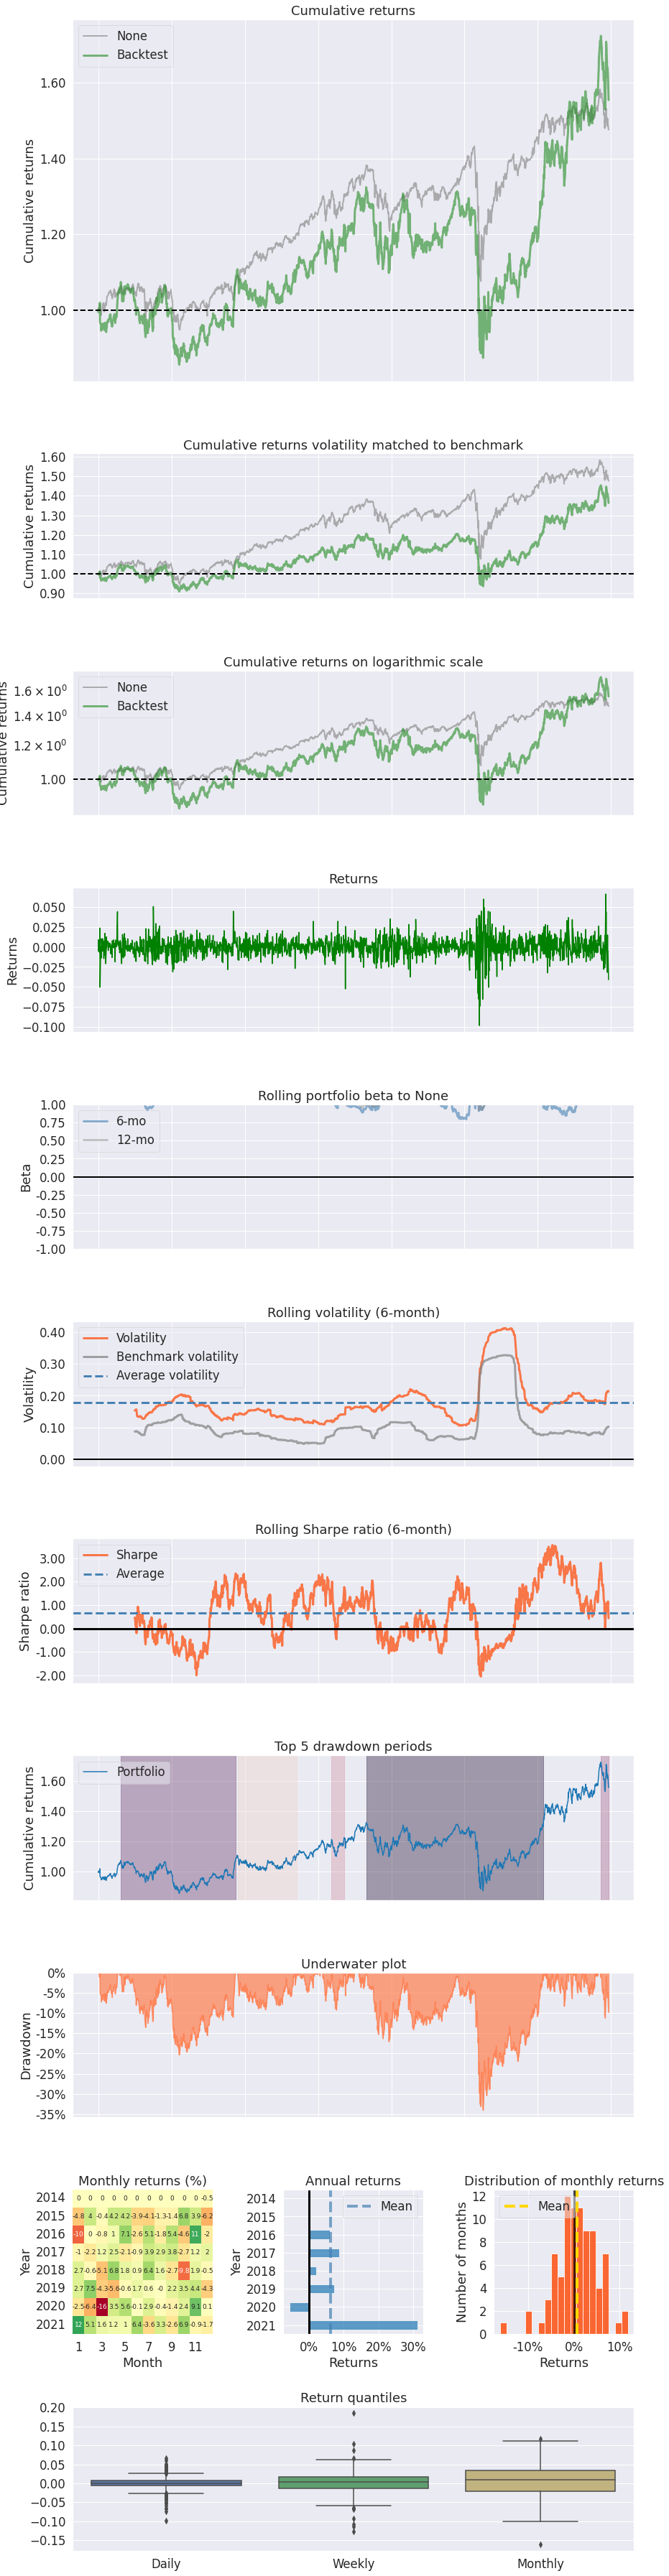

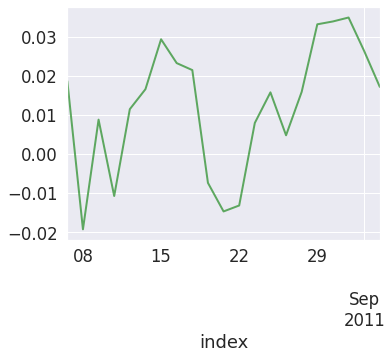

In [3]:
ben = ben[(ben.index <= max(returns.index)) & (ben.index >= min(returns.index))]
pf.create_full_tear_sheet(returns,  benchmark_rets =ben)
filename = f'{PATH_TO_SEC_DATA}/cerebros/returns_St{name_st}'
outfile = open(filename,'wb')
pickle.dump(returns,outfile)
outfile.close()
filename = f'{PATH_TO_SEC_DATA}/cerebros/benchmark_St{name_st}'
outfile = open(filename,'wb')
pickle.dump(ben,outfile)
outfile.close()
filename = f'{PATH_TO_SEC_DATA}/cerebros/transactions_St{name_st}'
outfile = open(filename,'wb')
pickle.dump(transactions,outfile)
outfile.close()
filename = f'{PATH_TO_SEC_DATA}/cerebros/positions_St{name_st}'
outfile = open(filename,'wb')
pickle.dump(positions,outfile)
outfile.close()